## Hotel Booking Demand - Modelling

<img src="https://github.com/robinyUArizona/MIS-586-Big-Data-Project/blob/master/hotel_booking_pic.PNG?raw=true" style="width:1100px;height:300px" />

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


" Other libraries "
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer

from sklearn.tree import DecisionTreeClassifier # Decision Tree
from sklearn.linear_model import LogisticRegression # Logistic Regression
from sklearn.naive_bayes import GaussianNB # Naives Bayes
from sklearn.neural_network import MLPClassifier # Neural Network

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE


from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# Load the data
from google.colab import files
uploaded = files.upload()

Saving hotel.csv to hotel.csv


In [3]:
hotel_df = pd.read_csv('hotel.csv')

display(hotel_df.head())
print(hotel_df.info())

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,meal,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,adr,required_car_parking_spaces,total_of_special_requests
0,Resort Hotel,0,7,1,July,27,1,0,1,1,0.0,BB,Direct,Direct,0,0,0,A,C,0,No Deposit,75.0,0,0
1,Resort Hotel,0,13,1,July,27,1,0,1,1,0.0,BB,Corporate,Corporate,0,0,0,A,A,0,No Deposit,75.0,0,0
2,Resort Hotel,0,14,1,July,27,1,0,2,2,0.0,BB,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,98.0,0,1
3,Resort Hotel,0,0,1,July,27,1,0,2,2,0.0,BB,Direct,Direct,0,0,0,C,C,0,No Deposit,107.0,0,0
4,Resort Hotel,0,9,1,July,27,1,0,2,2,0.0,FB,Direct,Direct,0,0,0,C,C,0,No Deposit,103.0,0,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83522 entries, 0 to 83521
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           83522 non-null  object 
 1   is_canceled                     83522 non-null  int64  
 2   lead_time                       83522 non-null  int64  
 3   arrival_date_year               83522 non-null  int64  
 4   arrival_date_month              83522 non-null  object 
 5   arrival_date_week_number        83522 non-null  int64  
 6   arrival_date_day_of_month       83522 non-null  int64  
 7   stays_in_weekend_nights         83522 non-null  int64  
 8   stays_in_week_nights            83522 non-null  int64  
 9   adults                          83522 non-null  int64  
 10  children                        83522 non-null  float64
 11  meal                            83522 non-null  object 
 12  market_segment                  

Text(0, 0.5, 'Total Count')

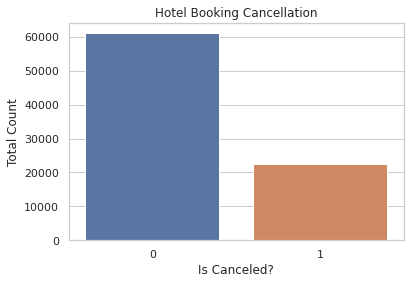

In [4]:
## Create X (features) and y(response)
X_features = hotel_df.drop('is_canceled', axis=1)
# display(X_features.head())
y_target = hotel_df.is_canceled
# display(y_target.head())

## is_cancelled
plt.figure(figsize=(6, 4))
sns.set(style="whitegrid")
ax = sns.countplot(x="is_canceled", data=hotel_df)
plt.title('Hotel Booking Cancellation')
plt.xlabel('Is Canceled?')
plt.ylabel('Total Count')

# checking frequncy of target classes
# y_target.value_counts()


## Baseline Accuracy

In [5]:
""" Baseline Accuracy """

booking_cancel = (hotel_df['is_canceled'] == 1).sum()
print("No. of booking canceled: ", booking_cancel)
not_booking_cancel = (hotel_df['is_canceled'] == 0).sum()
print("No. of booking not canceled: ", not_booking_cancel)
total_booking = booking_cancel + not_booking_cancel
print("Total count: ", total_booking)
print("\n\nBaseline Accuracy based on majority class:")
print("% of booking cancelation: ", (not_booking_cancel/total_booking) * 100, "%" )

No. of booking canceled:  22461
No. of booking not canceled:  61061
Total count:  83522


Baseline Accuracy based on majority class:
% of booking cancelation:  73.10768420296448 %


## Encoding - Scaling Datasets
- Splitting the datasets into train and test datasets
- Lisiting numerical and categorical features
- Encoding and Scaling train and test datasets
- Finally checking the number of columns in both train and test datasets


###  Splitting dataset into Train and Test datasets

In [6]:
# ## Splitiing hotel datasets into training and testing datasets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size = 0.3, 
                                                    random_state=0, stratify=y_target)

print ("Dimension of Training Dataset: ", X_train.shape)
display(X_train.head())
print ("Dimension of Testing Dataset: ", X_test.shape)
display(X_test.head())

Dimension of Training Dataset:  (58465, 23)


,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,meal,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,adr,required_car_parking_spaces,total_of_special_requests
32191,City Hotel,0,1,August,33,11,0,1,2,0.0,BB,Online TA,Direct,0,0,0,A,A,0,No Deposit,99.00,0,1
37328,City Hotel,51,2,April,18,27,0,1,1,0.0,BB,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,119.70,0,0
63828,City Hotel,162,2,August,33,11,2,3,3,0.0,BB,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,96.90,0,0
26787,Resort Hotel,46,3,March,11,18,1,1,2,0.0,BB,Direct,Corporate,0,0,0,A,A,0,No Deposit,60.00,0,0
2517,Resort Hotel,19,1,November,45,7,0,1,2,1.0,BB,Offline TA/TO,TA/TO,0,0,0,A,D,0,No Deposit,32.62,0,1


Dimension of Testing Dataset:  (25057, 23)


,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,meal,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,adr,required_car_parking_spaces,total_of_special_requests
75071,City Hotel,59,3,March,13,30,1,3,2,0.0,BB,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,89.10,0,0
59992,City Hotel,118,2,June,24,6,1,2,1,0.0,BB,Offline TA/TO,Corporate,0,0,0,A,A,0,No Deposit,110.00,0,0
1288,Resort Hotel,25,1,August,35,28,2,2,2,0.0,FB,Direct,Direct,0,0,0,F,F,1,No Deposit,208.00,0,2
34337,City Hotel,55,1,October,44,28,0,4,3,0.0,BB,Offline TA/TO,TA/TO,0,0,0,D,D,0,No Deposit,112.50,0,1
70553,City Hotel,35,2,December,52,19,1,3,1,0.0,BB,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,63.75,0,0


### List of numerical and categorical features

In [7]:
""" List of numerical and categorical columns """
def num_cat(df):
    
    num_int_type = df.select_dtypes(include='int64').columns.tolist()
    num_float_type = df.select_dtypes(include='float64').columns.tolist()
    num_type = num_int_type + num_float_type

    cat_object_type = df.select_dtypes(include='object').columns.tolist()
    
    return num_type, cat_object_type

num_type_tn, cat_obj_type_tn = num_cat(X_train)
print("Features of Train Dataset:\n")
print(num_type_tn, cat_obj_type_tn)
num_type_tt, cat_obj_type_tt = num_cat(X_test)
print("\n\nFeatures of Test Dataset:\n")
print(num_type_tt, cat_obj_type_tt)

Features of Train Dataset:

['lead_time', 'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'required_car_parking_spaces', 'total_of_special_requests', 'children', 'adr'] ['hotel', 'arrival_date_month', 'meal', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'deposit_type']


Features of Test Dataset:

['lead_time', 'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'required_car_parking_spaces', 'total_of_special_requests', 'children', 'adr'] ['hotel', 'arrival_date_month', 'meal', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'deposit_ty

In [8]:
""" 
    - Preprocessing datasets for modeling
    - Scaling and encoding  
"""
## Encoding categoirical variables to numeric type - understandable to machine learning model
## scaling numerical variables with mean "0" and standard devaition "1"

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer

def num_cat_transformer(num_type, cat_object_type):
    # Preprocessing for numerical features:
    num_transformer = make_pipeline(StandardScaler(),
                                    SimpleImputer(strategy='constant'))

    # Preprocessing for categorical features:
    cat_transformer = make_pipeline(SimpleImputer(strategy='constant'),
                                    OneHotEncoder(sparse=False, handle_unknown='ignore'))

    ## Transforming both numerical and catergorical columns based preprocessing above
    column_transformer = make_column_transformer((num_transformer, num_type),
                                                   (cat_transformer, cat_object_type))
    return column_transformer

column_transformer_tn = num_cat_transformer(num_type_tn, cat_obj_type_tn)
X_train = pd.DataFrame(column_transformer_tn.fit_transform(X_train))
print("Encoded and Scaled of the Train dataset ")
display(X_train.head())

X_test = pd.DataFrame(column_transformer_tn.transform(X_test))
print("Encoded and Scaled of the Test dataset ")
display(X_test.head())


Encoded and Scaled of the Train dataset 


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
0,-0.981129,-1.749815,0.452817,-0.548102,-1.037855,-0.884236,0.251875,-0.203596,-0.087309,-0.128911,-0.387176,-0.304146,0.366032,-0.301496,-0.139099,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-0.285682,-0.292321,-0.638059,1.263693,-1.037855,-0.884236,-1.708696,-0.203596,-0.087309,-0.128911,-0.387176,-0.304146,-0.845474,-0.301496,0.269674,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.227937,-0.292321,0.452817,-0.548102,1.151231,0.320805,2.212445,-0.203596,-0.087309,-0.128911,-0.387176,-0.304146,-0.845474,-0.301496,-0.180569,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,-0.353863,1.165172,-1.147134,0.244559,0.056688,-0.884236,0.251875,-0.203596,-0.087309,-0.128911,-0.387176,-0.304146,-0.845474,-0.301496,-0.909252,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-0.722041,-1.749815,1.325518,-1.001050,-1.037855,-0.884236,0.251875,-0.203596,-0.087309,-0.128911,-0.387176,-0.304146,0.366032,1.937988,-1.449938,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Encoded and Scaled of the Test dataset 


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
0,-0.176593,1.165172,-1.001684,1.603405,0.056688,0.320805,0.251875,-0.203596,-0.087309,-0.128911,-0.387176,-0.304146,-0.845474,-0.301496,-0.334600,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.627944,-0.292321,-0.201708,-1.114288,0.056688,-0.281716,-1.708696,-0.203596,-0.087309,-0.128911,-0.387176,-0.304146,-0.845474,-0.301496,0.078123,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-0.640224,-1.749815,0.598267,1.376931,1.151231,-0.281716,0.251875,-0.203596,-0.087309,-0.128911,1.118393,-0.304146,1.577537,-0.301496,2.013378,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,-0.231137,-1.749815,1.252793,1.376931,-1.037855,0.923326,2.212445,-0.203596,-0.087309,-0.128911,-0.387176,-0.304146,0.366032,-0.301496,0.127492,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-0.503862,-0.292321,1.834593,0.357796,0.056688,0.320805,-1.708696,-0.203596,-0.087309,-0.128911,-0.387176,-0.304146,-0.845474,-0.301496,-0.835199,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [0]:
# # add missing columns to test dataset with all values being 0
# for i in X_train.columns:
#     if i not in X_test.columns: X_test[i] = 0
# print("Checking the no. of columns in test dataset")
# display(X_test.head())

# # add missing columns to train dataset with all values being 0
# for i in X_test.columns:
#     if i not in X_train.columns: X_train[i] = 0
# print("\nChecking the no. of columns in test dataset")
# display(X_train.head())

# # use the same column order for the test set as for train
# X_test = X_test.reindex(X_train.columns, axis=1)
# display(X_test.head())

### Model Evaluation

In [0]:
# # split1 = KFold(n_splits=5, shuffle=False, random_state=None)
# split2 = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

# # for train_ix, test_ix in split2.split(X_features, y_target):
# #     # select rows
# #     train_X, test_X = X_features.loc[train_ix], X_features.loc[test_ix]
# #     train_y, test_y = y_target[train_ix], y_target[test_ix]
# #     # summarize train and test composition
# #     train_0, train_1 = len(train_y[train_y==0]), len(train_y[train_y==1])
# #     test_0, test_1 = len(test_y[test_y==0]), len(test_y[test_y==1])
# #     print('>Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))

In [0]:
"""  Imbalance dataset - upsampling """

from collections import Counter

def upsampling_data(X, y):
    # Upsampling the training set
    # Upsample using SMOTE
    sm = SMOTE(sampling_strategy='auto', random_state=42)
    X_sm, y_sm = sm.fit_sample(X_train, y_train)
    
    print("Before SMOTE: ", Counter(y_train))
    print("After SMOTE: ", Counter(y_sm))
    return X_sm, y_sm


""" Training Model """
def train_model(model, X, y, num_procs, metrics):
    
    # split1 = KFold(n_splits=5, shuffle=False, random_state=None)
    split2 = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    
    # get cross validation score for each model:
    cv_score = cross_val_score(model, X, y,
                               cv=split2,
                               scoring=metrics,
                               n_jobs=-1).mean()
    return cv_score


""" Model Prediction """
def model_predict(model, X_trainn, y_trainn, X_topredict, y_true):    
    model.fit(X_trainn, y_trainn)
    y_pred = model.predict(X_topredict)
    
    class_report = classification_report(y_test, y_pred)
    disp_roc = plot_roc_curve(model, X_topredict, y_true)
    conf_matrix = plot_confusion_matrix(model, X_topredict, y_true, 
                                        cmap='Blues')
    
    return class_report, disp_roc, conf_matrix


===================== Beginning cross validation ========================== 

Model: 
 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Before SMOTE:  Counter({0: 42742, 1: 15723})
After SMOTE:  Counter({0: 42742, 1: 42742})

 Precision obtained from CV on Train Data: 0.8072
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.82      0.83     18319
           1       0.53      0.54      0.53      6738

    accuracy                           0.75     25057
   macro avg       0.68      0.68      0.68     25057
weighted avg       0.75      0.75      0.75     25057

ROC curve: 
Confusion Matrix Plot:  <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x7f7788bef9e8>
Confusion Matrix: 
 [[15090  3229]
 [ 3099  3639]]


Model: 
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2', random_state=42,
                   solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Before SMOTE:  Counter({0: 42742, 1: 15723})
After SMOTE:  Counter({0: 42742, 1: 42742})

 Precision obtained from CV on Train Data: 0.7095
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.94      0.87     18319
           1       0.69      0.39      0.50      6738

    accuracy                           0.79     25057
   macro avg       0.75      0.66      0.68     25057
weighted avg       0.78      0.79      0.77     25057

ROC curve: 
Confusion Matrix Plot:  <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x7f7788ac1b70>
Confusion Matrix: 
 [[17155  1164]
 [ 4130  2608]]


Model: 
 GaussianNB(priors=None, var_smoothing=1e-09)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Before SMOTE:  Counter({0: 42742, 1: 15723})
After SMOTE:  Counter({0: 42742, 1: 42742})

 Precision obtained from CV on Train Data: 0.9063
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.99      0.85     18319
           1       0.74      0.04      0.08      6738

    accuracy                           0.74     25057
   macro avg       0.74      0.52      0.46     25057
weighted avg       0.74      0.74      0.64     25057

ROC curve: 
Confusion Matrix Plot:  <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x7f77851bfb38>
Confusion Matrix: 
 [[18223    96]
 [ 6459   279]]


Model: 
 MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(13, 13, 13), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=500,
              momentum=0.9, n_iter_no

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Before SMOTE:  Counter({0: 42742, 1: 15723})
After SMOTE:  Counter({0: 42742, 1: 42742})

 Precision obtained from CV on Train Data: 0.7809
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.91      0.87     18319
           1       0.68      0.53      0.60      6738

    accuracy                           0.81     25057
   macro avg       0.76      0.72      0.73     25057
weighted avg       0.80      0.81      0.80     25057

ROC curve: 
Confusion Matrix Plot:  <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x7f7785105c50>
Confusion Matrix: 
 [[16643  1676]
 [ 3163  3575]]



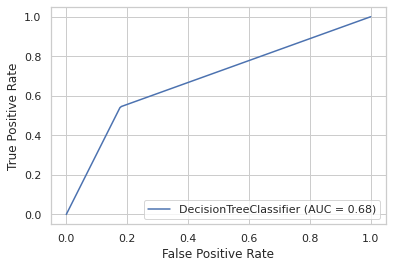

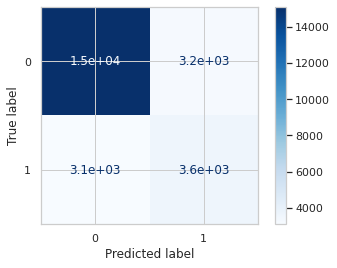

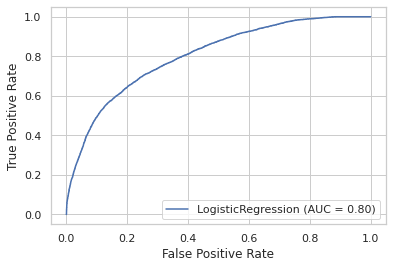

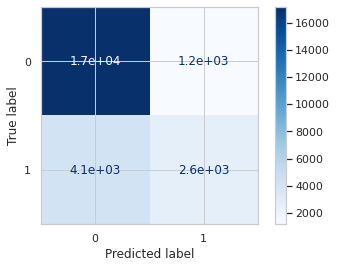

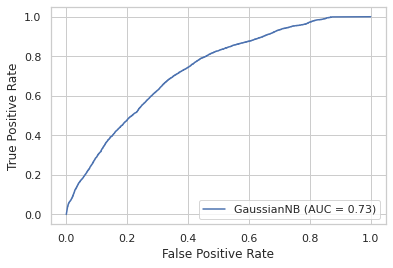

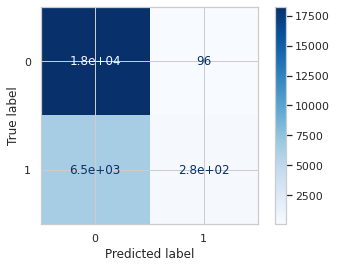

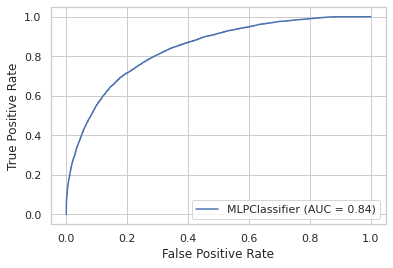

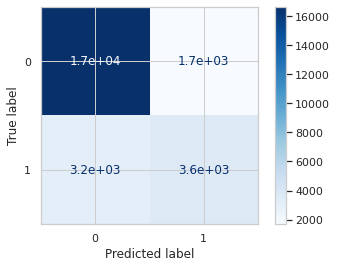

In [12]:
"""
    Evaluating Models
    - Decision Trees
    - Logistic Regression
    - Naive Bayes
    - Neural Network

"""

# intialize the model list and dicts
models = []
mean_score = {}
std_dev = {}
# res = {}

# define number of processes to run in parallel
num_procs = -1

# shared model parameters
verbose_lvl = 0

# create models  
DT_model = DecisionTreeClassifier(random_state=42)
Logreg_model = LogisticRegression(random_state=42, n_jobs=-1)
GNM_model = GaussianNB()
MLP_model = MLPClassifier(hidden_layer_sizes=(13,13,13), max_iter=500)

# list all models
models.extend([DT_model, Logreg_model, GNM_model, MLP_model])

# parallel cross-validate models, using mean precision as evaluation metric, and print summaries
print("===================== Beginning cross validation ========================== ")


for model in models:
    print("\nModel: \n", model)
    # Calling train_model()
    X_train_sm, y_train_sm = upsampling_data(X_train, y_train)
    cv_score = train_model(model, X_train_sm, y_train_sm, num_procs,'precision')
    print("\n Precision obtained from CV on Train Data:", round(cv_score, 4))
    class_report, disp_roc, conf_matrix = model_predict(model, X_train, y_train, X_test, y_test)
    print("Classification Report:\n", class_report)
    print("ROC curve: \n", disp_roc)
    print("Confusion Matrix Plot: ", conf_matrix)
    print("Confusion Matrix: \n", conf_matrix.confusion_matrix)

    print("==================================================================================\n")

## Hyperparameters tuning for the best model

- MLP Classifier
- Logistic Regression


In [0]:

mlp = MLPClassifier(hidden_layer_sizes=(13,13,13), max_iter=500)

In [14]:
mlp.get_params()

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (13, 13, 13),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 500,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

## Using a grid search

In [0]:
from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import RandomizedSearchCV
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [16]:

params = {}
params['hidden_layer_sizes'] = [(13,13,13), (10,10,9)]
params['activation'] = ['tanh', 'relu']
params['alpha'] = [0.0001, 0.05, 0.005]
# params['learning_rate'] = ['constant', 'adaptive']
params

{'activation': ['tanh', 'relu'],
 'alpha': [0.0001, 0.05, 0.005],
 'hidden_layer_sizes': [(13, 13, 13), (10, 10, 9)]}

In [17]:
grid_clf = GridSearchCV(mlp, params, cv=10, scoring='precision')
grid_clf.fit(X_train, y_train)

grid_clf.best_params_

{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (13, 13, 13)}

In [18]:
grid_clf.best_score_

0.7124892960517301

In [0]:
y_pred = grid_clf.predict(X_test)
# y_pred

In [20]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.92      0.88     18319
           1       0.70      0.52      0.60      6738

    accuracy                           0.81     25057
   macro avg       0.77      0.72      0.74     25057
weighted avg       0.80      0.81      0.80     25057



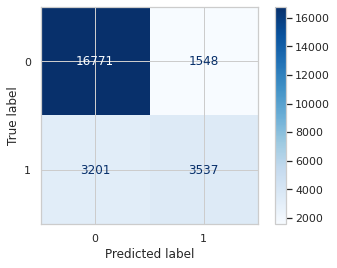

In [21]:
# pass it a trained model: it makes predictions for X_test and compares them to y_test
disp = plot_confusion_matrix(grid_clf, X_test, y_test, cmap='Blues', values_format='d')

In [0]:
logreg = LogisticRegression(solver='liblinear', random_state=42)

In [23]:
logreg.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [24]:
params = {}
params['penalty'] = ['l1', 'l2']
params['C'] = [0.1, 1, 10]
params

{'C': [0.1, 1, 10], 'penalty': ['l1', 'l2']}

In [0]:
grid_logreg = GridSearchCV(logreg, params, cv=5, scoring='precision')
grid_logreg.fit(X_train, y_train);

In [26]:
grid_logreg.best_params_

{'C': 0.1, 'penalty': 'l2'}

In [27]:
grid_logreg.best_score_

0.6847338543275588

In [0]:
y_pred_logreg = grid_logreg.predict(X_test)
# y_pred_logreg

In [29]:
print(classification_report(y_test, y_pred_logreg))

              precision    recall  f1-score   support

           0       0.80      0.94      0.87     18319
           1       0.69      0.38      0.49      6738

    accuracy                           0.79     25057
   macro avg       0.75      0.66      0.68     25057
weighted avg       0.77      0.79      0.77     25057



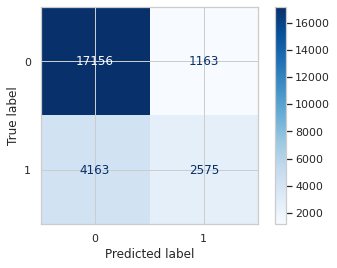

In [30]:
# pass it a trained model: it makes predictions for X_test and compares them to y_test
disp = plot_confusion_matrix(grid_logreg, X_test, y_test, cmap='Blues', values_format='d')